Leaf Sgmentation Project 

In [286]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
import skimage
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops, regionprops_table




Segmenting function's implementation

Function for detecting needle leaves

In [287]:
def conifer_deduction(path):
    img=cv.imread(path)
    seg=threshold_otsu(path)
    label_img, num_of_labels = label(seg,return_num=True)
    df = pd.DataFrame( regionprops_table(label_img,img,properties=
                                        [
                                        'major_axis_length', 
                                        'minor_axis_length']))
    
    df2['axis_ratio']=df2['major_axis_length']/df2['minor_axis_length']
    return df2['axis_ratio'].max()>2
    
    
    

Canny edge segmentations algorithms variants

In [288]:
def fill_edges(thresh):
    h, w = thresh.shape[:2]
    im_flood_fill=thresh.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    if im_flood_fill[1,1] == True:
        im_flood_fill =cv.bitwise_not(im_flood_fill)
    cv.floodFill(im_flood_fill,mask,(1,1),255)
    return im_flood_fill

In [289]:
def canny_segmentation(path):
    img=cv.imread(path,0)
    edges=cv.Canny(img,100,200)
    rect=cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    dilation = cv.dilate(edges,rect,iterations = 2)
    erosion = cv.erode(dilation, rect, iterations=1)
    filled=fill_edges(erosion)
    filled=cv.bitwise_not(filled)
    return filled
   
    


In [290]:
def canny_with_sharpening(path):
    img=cv.imread(path,0)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img = cv.filter2D(img, -1, kernel)
    edges=cv.Canny(img,100,200)
    rect=cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    dilation = cv.dilate(edges,rect,iterations = 2)
    erosion = cv.erode(dilation, rect, iterations=1)
    filled=fill_edges(erosion)
    filled=cv.bitwise_not(filled)
    return filled

In [291]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened


def canny_with_unsharpening(path):
    img=cv.imread(path,0)
    img=unsharp_mask(img)
    edges=cv.Canny(img,100,200)
    rect=cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    dilation = cv.dilate(edges,rect,iterations = 2)
    erosion = cv.erode(dilation, rect, iterations=1)
    filled=fill_edges(erosion)
    filled=cv.bitwise_not(filled)
    return filled

Otsu segmentation implementation

In [292]:
def otsu_segmentation(path):
    img=cv.imread(path,0)
    img = cv.GaussianBlur(img,(5,5),0)
    ret1,th1=cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    if(conifer_deduction==False):
        rect=cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
        dilation = cv.dilate(th1,rect,iterations = 2)
        erosion = cv.erode(dilation, rect, iterations=1)
        th1=cv.bitwise_not(th1)
        th1=cv.medianBlur(th1,9)
    else:
        th1=cv.bitwise_not(th1)
    return th1

Binary segmentation implementation

In [293]:
def binary_segmentation(path):
    img=cv.imread(path,0)
    img = cv.GaussianBlur(img,(5,5),0)
    ret1,th1=cv.threshold(img,127,255,cv.THRESH_BINARY)
    if(conifer_deduction==False):
        th1=cv.bitwise_not(th1)
        th1=cv.medianBlur(img,3)
        rect=cv.getStructuringElement(cv.MORPH_RECT, (10, 10))
        dilation = cv.dilate(th1,rect,iterations = 2)
        erosion = cv.erode(dilation, rect, iterations=1)
        ret1,erosion=cv.threshold(erosion,127,255,cv.THRESH_BINARY)
        erosion=cv.bitwise_not(erosion)
        return erosion
    return cv.bitwise_not(th1)
    

Function to asses segmentation corectness

In [294]:
import re 
def findbackground(path):
    return re.sub(r'color_images','ground_truth',path)

def Dice(segmentation,ground):
    
    
    intersection=cv.bitwise_and(segmentation,ground)
    intersection=np.count_nonzero(intersection>0)
    A=np.count_nonzero(segmentation>0)
    B=np.count_nonzero(ground>0)
    return 2 * intersection /(A+B)

def IntersectionOverUnion(segmentation,ground):
   
    
    intersection=cv.bitwise_and(segmentation,ground)
    intersection=np.count_nonzero(intersection>0)
    image_union=cv.bitwise_or(segmentation,ground)
    image_union=np.count_nonzero(image_union>0)
    return intersection/image_union


    
    


def compare_segmentations(path):
    background=findbackground(path)
    background=cv.imread(background,0)
    otsu=otsu_segmentation(path)
    canny=canny_segmentation(path)
    binary=binary_segmentation(path)
    canny_sharpened=canny_with_sharpening(path)
    canny_unsharpened = canny_with_unsharpening(path)
    return path, IntersectionOverUnion(binary,background),Dice(binary,background), IntersectionOverUnion(otsu,background),Dice(otsu,background), IntersectionOverUnion(canny,background),Dice(canny,background), IntersectionOverUnion(canny_sharpened,background),Dice(canny_sharpened,background),IntersectionOverUnion(canny_unsharpened,background),Dice(canny_unsharpened,background)








browsing all files over given dataset

In [295]:
import glob
import os
import pandas as pd
# df = pd.DataFrame(columns=['path','Intersection over Union binary','Dice binary','Intersection over Union otsu','Dice otsu','Intersection over Union canny','Dice canny'])
columns=['path','Intersection_over_Union binary','Dice_binary','Intersection_over_Union_otsu','Dice_otsu','Intersection_over_Union_canny','Dice_canny','Intersection_over_Union_canny_sharpened','Dice_canny_sharpened','Intersection_over_Union_canny_unsharpened','Dice_canny_unsharpened']


files1 = glob.glob(os.path.join('leaf_dataset','leaves_testing_set_1','color_images','*.png'))


lst = []
for file in files1:
   path,Ibinary,Dbinary,Iotsu,Dotsu,ICanny,Dcanny,Icannysharpened,Dcannysharpened,Icannyunsharpened,Dcannyunsharpened = compare_segmentations(file)
   lst.append([path,Ibinary,Dbinary,Iotsu,Dotsu,ICanny,Dcanny,Icannysharpened,Dcannysharpened,Icannyunsharpened,Dcannyunsharpened])

df1=pd.DataFrame(columns=columns,data=lst)

files2=glob.glob(os.path.join('leaf_dataset','leaves_testing_set_2','color_images','*.png'))

lst = []
for file in files2:
   path,Ibinary,Dbinary,Iotsu,Dotsu,ICanny,Dcanny,Icannysharpened,Dcannysharpened,Icannyunsharpened,Dcannyunsharpened = compare_segmentations(file)
   lst.append([path,Ibinary,Dbinary,Iotsu,Dotsu,ICanny,Dcanny,Icannysharpened,Dcannysharpened,Icannyunsharpened,Dcannyunsharpened])
  
df2=pd.DataFrame(columns=columns,data=lst)


Summaries of segmentations reports

In [296]:
df1.drop(['Intersection_over_Union_canny','Dice_canny','Intersection_over_Union_canny_sharpened','Dice_canny_sharpened'],inplace=True,axis=1)
df1.describe().to_csv('dataset1_describe.csv')
df1.describe()
dh1=df1.describe()


In [297]:
df2.drop(['Intersection_over_Union_canny','Dice_canny','Intersection_over_Union_canny_sharpened','Dice_canny_sharpened'],inplace=True,axis=1)
df2.describe().to_csv('dataset2_describe.csv')
df2.describe()
dh2=df2.describe()

In [298]:
df3 =df2.append(df1)
# df3.describe().tocsv('dataset_merged_describe.csv')
# df3.drop(['Intersection_over_Union_canny','Dice_canny','Intersection_over_Union_canny_sharpened','Dice_canny_sharpened'],inplace=True,axis=1)
df3.describe()
dh3=df3.describe()

<AxesSubplot:ylabel='Frequency'>

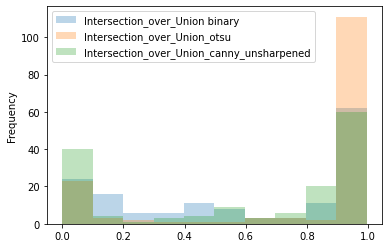

In [299]:
df1.drop(['Dice_binary','Dice_otsu','Dice_canny_unsharpened' ],inplace=True,axis=1)
df1.plot.hist(alpha=0.3)

<AxesSubplot:ylabel='Frequency'>

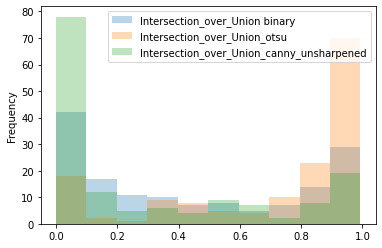

In [300]:
df2.drop(['Dice_binary','Dice_otsu','Dice_canny_unsharpened'],inplace=True,axis=1)
df2.plot.hist(alpha=0.3)

<AxesSubplot:ylabel='Frequency'>

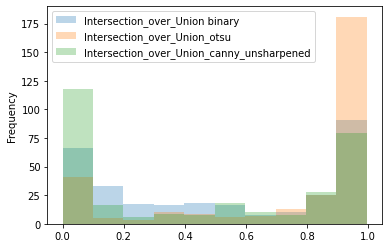

In [301]:
df3.drop(['Dice_binary','Dice_otsu','Dice_canny_unsharpened'],inplace=True,axis=1)
df3.plot.hist(alpha=0.3)